troy sleeps too much and Josie takes too long


In [ ]:
# this is most likely more imports than we need, it is occasionally getting updated
# attempted to remove things we dont use but some may still exist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score as ps, recall_score as rs, f1_score as f1
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.neural_network import MLPClassifier, MLPRegressor

from keras.models import Sequential, save_model, load_model, Model
from keras import layers
from keras.utils import to_categorical
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import MultiHeadAttention, Input, Dense, Dropout, Flatten, LSTM, GlobalAveragePooling1D, LayerNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

import warnings
def ToggleWarnings(w) -> None:
    if w:
        warnings.filterwarnings('ignore')
        print("Warnings have been disabled")
        w = False
    else:
        warnings.filterwarnings('default')
        print("Warnings have been enabled")
        w = True
ToggleWarnings(True)

Warnings have been disabled


In [ ]:
# upload file from computer

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  games_df = pd.read_csv(fn)
  print(games_df.head())


Saving Season-2010-2019ExtraFeatures.csv to Season-2010-2019ExtraFeatures (1).csv
   season  week week_day  event_date tm_alias opp_alias  tm_score  opp_score  \
0    2010     1      Thu  2010-09-09       NO       MIN        14          9   
1    2010     1      Sun  2010-09-12      PIT       ATL        15          9   
2    2010     1      Sun  2010-09-12      BUF       MIA        10         15   
3    2010     1      Sun  2010-09-12      CHI       DET        19         14   
4    2010     1      Sun  2010-09-12       NE       CIN        38         24   

                                 boxscore_stats_link  PointDiff  ...  \
0  https://www.pro-football-reference.com/boxscor...          5  ...   
1  https://www.pro-football-reference.com/boxscor...          6  ...   
2  https://www.pro-football-reference.com/boxscor...         -5  ...   
3  https://www.pro-football-reference.com/boxscor...          5  ...   
4  https://www.pro-football-reference.com/boxscor...         14  ...   

   P

In [ ]:
# FEATURE ENGINEERING (I did this in jupyter so we can upload the finished rewritten CSV)
# I absolutely HATE the upload and save as
games_df = pd.read_csv("NEWDBS/Season-2010-2019.csv")
games_df["event_date"] = pd.to_datetime(games_df["event_date"])

# Coldrop array
cols_to_drop = [
    "status",
    "tm_nano", "opp_nano",
    "tm_market", "tm_name", "tm_alt_market",
    "opp_market", "opp_name", "opp_alt_market",
    "tm_alt_alias", "opp_alt_alias",
]
games_df = games_df.drop(columns=cols_to_drop)

# Regular season only (week 1–17)
games_df = games_df[games_df["week"].between(1, 17)].copy()

# Swap if team is NOT home and opp IS home
swap_home_mask = (games_df["tm_location"] != "H") & (games_df["opp_location"] == "H")

# True if either side has neutral location
neutral_mask = (games_df["tm_location"] == "N") | (games_df["opp_location"] == "N")
# If it's a neutral site, order alphabetically (this happens so extremely rarely, it's negligible)
swap_neutral_mask = (
    neutral_mask
    & (games_df["tm_location"] != "H")
    & (games_df["opp_location"] != "H")
    & (games_df["tm_alias"] > games_df["opp_alias"]))
# True if NEITHER team is marked home

swap_mask = swap_home_mask | swap_neutral_mask
#True for rows that neew swapping for either home/away or neutral site reasons


# The pairs of rows that are getting switched by the swap masks
swap_pairs = [
    ("tm_alias", "opp_alias"), # Team
    ("tm_location", "opp_location"), # H/A/N
    ("tm_score", "opp_score"), # Score (obviously)
]


# The tm_ and opp_ will change so that tm is always home
for a, b in swap_pairs:
    tmp = games_df.loc[swap_mask, a].copy() # Selects rows that need swapping
    games_df.loc[swap_mask, a] = games_df.loc[swap_mask, b].values #
    games_df.loc[swap_mask, b] = tmp.values



# Targets
games_df["PointDiff"] = games_df["tm_score"] - games_df["opp_score"] # home margin (>0 is a win | <=0 is a loss)
games_df["Win"] = (games_df["PointDiff"] > 0).astype(int) # home win (1 = win, 0 = loss [for home team])

# Long format (one row per team-game)
# also renames columns to be easier to recognize
team_view_df = games_df[[
    "season","week","event_date","boxscore_stats_link",
    "tm_alias","opp_alias","tm_location","tm_score","opp_score","Win","PointDiff"
]].copy()
team_view_df.columns = [
    "season","week","event_date","game_id",
    "team","opponent","location","points_for","points_against","win","pt_diff"
]

# Recompute pt_diff & win from new score columns
team_view_df["pt_diff"] = team_view_df["points_for"] - team_view_df["points_against"]
team_view_df["win"] = (team_view_df["pt_diff"] > 0).astype(int)


# Takes data for opponent row
opp_view_df = games_df[[
    "season","week","event_date","boxscore_stats_link",
    "opp_alias","tm_alias","opp_location","opp_score","tm_score","PointDiff"
]].copy()
opp_view_df.columns = [
    "season","week","event_date","game_id",
    "team","opponent","location","points_for","points_against","pt_diff"
]
opp_view_df["win"] = (opp_view_df["pt_diff"] < 0).astype(int)  # opponent wins if tm lost
opp_view_df["pt_diff"] = -opp_view_df["pt_diff"]


# Stack datasets, makes each game have 2 rows (one per team)
team_games_df = pd.concat([team_view_df, opp_view_df], ignore_index=True)
# Put each team's game in chronological order
team_games_df = team_games_df.sort_values(["team", "season", "event_date", "week", "game_id"]).reset_index(drop=True)

# Rolling features (last 3/5/8 games)
rolling_windows = [3, 5, 8]

# Group by team & season (so week 1 doesn't use last year's games in rolling stats)
team_season_group = team_games_df.groupby(["team", "season"], group_keys=False)

# min_periods = n-1 (remember because of shift(1) thing I did) so ONLY prior games count
for n in rolling_windows:
    min_prev_games = n # Only compute rolling average when there are enough games played to calculate it
    # Since it's week 3/5/8, that means rolling averages technically are for weeks 4/6/9

    # Ok this is how the rolling window works:
    # s.shift(1) shifts the series down 1 so that the current game is EXCLUDED
    # rolling(n) takes the last n values of the shifted series
    # Sum is for total over those prior 3/5/8 games

    # This one is for how many points a team gives up
    team_games_df[f"PtsAgainst{n}"] = team_season_group["points_against"].apply(
        lambda s: s.shift(1).rolling(n, min_periods=min_prev_games).sum()
    )
    # This one is for how many points a team scores
    team_games_df[f"PtsFor{n}"] = team_season_group["points_for"].apply(
        lambda s: s.shift(1).rolling(n, min_periods=min_prev_games).sum()
    )
    # This one is the sum of all point differences to get a view if a team is buns or not
    team_games_df[f"PtDifference{n}"] = team_season_group["pt_diff"].apply(
        lambda s: s.shift(1).rolling(n, min_periods=min_prev_games).sum()
    )

    # This is for total wins in last N games
    team_games_df[f"WinLoss{n}"] = team_season_group["win"].apply(
        lambda s: s.shift(1).rolling(n, min_periods=min_prev_games).sum()
    )


# Rest days/time between games
team_season_group_for_rest = team_games_df.groupby(["team", "season"], group_keys=False)
team_games_df["RestDays"] = team_season_group_for_rest["event_date"].apply(lambda s: s.diff().dt.days)

# Season-to-date features (shifted to exclude current game)
team_season_group2 = team_games_df.groupby(["team", "season"], group_keys=False)
team_games_df["SznFor"] = team_season_group2["points_for"].apply(lambda s: s.shift(1).expanding(min_periods=1).sum())
team_games_df["SznAgainst"] = team_season_group2["points_against"].apply(lambda s: s.shift(1).expanding(min_periods=1).sum())
# For game 1, the shift makes it all NaN since there's no prior values, DON'T TOUCH IT OR IT *WILL* BREAK

# Record vs opponent in last 3 seasons (win rate)
def record3year(group: pd.DataFrame) -> pd.Series:
    group = group.sort_values(["event_date", "week", "game_id"]) # Sort chronologically
    past = []  # (season, win)
    out = []
    for _, row in group.iterrows():
        cutoff = row["season"] - 2  # Current season + previous 2 = 3 seasons
        vals = [w for (s, w) in past if s >= cutoff]
        # Mean win rate, BUT if no matchup history is present, then output NaN
        out.append(np.mean(vals) if vals else np.nan)
        # Adds current game rtesult AFTER computing history
        past.append((
            row["season"],
            row["win"]
        ))
    return pd.Series(out, index=group.index)

# Group by each team/opponent pairing across seasons
team_games_df["Record3Year"] = team_games_df.groupby(
    ["team", "opponent"], group_keys=False).apply(record3year)

# Merge features back (teamm + opp versions)
feature_cols = []
for n in rolling_windows:
    feature_cols += [f"PtsAgainst{n}", f"PtsFor{n}", f"PtDifference{n}", f"WinLoss{n}"]
feature_cols += ["SznFor", "SznAgainst", "Record3Year", "RestDays"]

# For each game/team, add the engineered features
team_features_df = team_games_df[["game_id", "team"] + feature_cols].copy()
# Make second df with opponent data (non-home team)
opp_features_df = team_features_df.rename(columns={c: f"Opp_{c}" for c in feature_cols})


# Merges home team engineered features
final_df = games_df.merge(
    team_features_df, left_on=["boxscore_stats_link", "tm_alias"],
    right_on=["game_id", "team"],
    how="left"
).merge(
    opp_features_df, left_on=["boxscore_stats_link",
                              "opp_alias"], right_on=["game_id", "team"], how="left"
) # Same thing but for opponent features ^
# Drop merge helper columns
final_df = final_df.drop(columns=["game_id_x","team_x","game_id_y","team_y"], errors="ignore")

# Neutral Site indicator
final_df["NeutralSite"] = ((final_df["tm_location"]=="N") | (final_df["opp_location"]=="N")).astype(int)
final_df = final_df.drop(columns=["tm_location","opp_location"])
# Neutralsite = 1 if either is neutral


# NaN handling
# 1) Rolling totals: add flags then fill NaNs with 0. Pls don't touch this part <3
for n in rolling_windows:
    final_df[f"HasRolling{n}"] = final_df[f"PtsFor{n}"].notna().astype(int)
    final_df[f"Opp_HasRolling{n}"] = final_df[f"Opp_PtsFor{n}"].notna().astype(int)

    roll_cols = [
        f"PtsAgainst{n}", f"PtsFor{n}", f"PtDifference{n}", f"WinLoss{n}",
        f"Opp_PtsAgainst{n}", f"Opp_PtsFor{n}", f"Opp_PtDifference{n}", f"Opp_WinLoss{n}",
    ]
    # This is so that the 0's in the beginning for rolling don't actually count as "real" 0's
    final_df[roll_cols] = final_df[roll_cols].fillna(0)

# Season-to-date totals- week 1 will be 0 prior points
final_df["HasSzn"] = final_df["SznFor"].notna().astype(int)
final_df["Opp_HasSzn"] = final_df["Opp_SznFor"].notna().astype(int)

# Fill with 0s to show no recorded scores yet
szn_cols = ["SznFor", "SznAgainst", "Opp_SznFor", "Opp_SznAgainst"]
final_df[szn_cols] = final_df[szn_cols].fillna(0)

# Rest days - week 1 has no prior game, so I filled it with 7 (default amount of rest) & keep a flag
final_df["HasRest"] = final_df["RestDays"].notna().astype(int)
final_df["Opp_HasRest"] = final_df["Opp_RestDays"].notna().astype(int)

final_df[["RestDays", "Opp_RestDays"]] = final_df[["RestDays", "Opp_RestDays"]].fillna(7)

# 4) Record vs opponent last 3 seasons if NaN, use 0.5 and keep a flag
final_df["HasRecord3Year"] = final_df["Record3Year"].notna().astype(int)
final_df["Opp_HasRecord3Year"] = final_df["Opp_Record3Year"].notna().astype(int)
final_df[["Record3Year", "Opp_Record3Year"]] = final_df[["Record3Year", "Opp_Record3Year"]].fillna(0.5)


####################################
# Keep this just in case if I need to drop this bc it only kicks in literally haflway thru the season:
#final_df = final_df.dropna(subset=["PtsFor8", "Opp_PtsFor8"])


# Difference features (team - opp)
for n in rolling_windows:
    final_df[f"PtsFor{n}Diff"]       = final_df[f"PtsFor{n}"] - final_df[f"Opp_PtsFor{n}"]
    final_df[f"PtsAgainst{n}Diff"]   = final_df[f"PtsAgainst{n}"] - final_df[f"Opp_PtsAgainst{n}"]
    final_df[f"PtDifference{n}Diff"] = final_df[f"PtDifference{n}"] - final_df[f"Opp_PtDifference{n}"]
    final_df[f"WinLoss{n}Diff"]      = final_df[f"WinLoss{n}"] - final_df[f"Opp_WinLoss{n}"]

final_df["SznForDiff"]      = final_df["SznFor"] - final_df["Opp_SznFor"]
final_df["SznAgainstDiff"]  = final_df["SznAgainst"] - final_df["Opp_SznAgainst"]
final_df["Record3YearDiff"] = final_df["Record3Year"] - final_df["Opp_Record3Year"]


final_df.to_csv("NEWDBS/Season-2010-2019ExtraFeatures.csv", index=False)
print(final_df.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'NEWDBS/Season-2010-2019.csv'

In [ ]:
# Split for train/test & validation

# LAST 4 SHOULD BE TOKENIZIED OR ONE HOT ENCODED
nonintcols = ["week", "week_day", "event_date", "boxscore_stats_link", "tm_alias", "opp_alias", "tm_score", "opp_score"]
edit_games_df = games_df.sort_values(["season", "week"])
edit_games_df = edit_games_df.drop(columns = nonintcols)

train_df = edit_games_df[edit_games_df["season"] <= 2017]
val_df = edit_games_df[edit_games_df["season"] == 2018]
test_df = edit_games_df[edit_games_df["season"] == 2019]

y_win_train = train_df["Win"]
y_win_val = val_df["Win"]
y_win_test = test_df["Win"]

y_pd_train = train_df["PointDiff"]
y_pd_val = val_df["PointDiff"]
y_pd_test = test_df["PointDiff"]

winTarget = "Win"
diffTarget = "PointDiff"
x_train = train_df.drop(columns = [winTarget, diffTarget])
x_val = val_df.drop(columns = [winTarget, diffTarget])
x_test = test_df.drop(columns = [winTarget, diffTarget])

In [ ]:
# i am including this here because i did run these and got outputs
# however they are massive and were saved as images for the sake of computation time & file size

# Hartley: "I wanna have that pattern on my walls"

# sns.pairplot(edit_games_df, hue = "PointDiff")
# sns.pairplot(edit_games_df, hue = "Win")

In [ ]:

############# ADDDED AFTER WE SUBMITTED TO TEST IF WE ARE STUPID OR NOT####
print(x_train.shape)
print([c for c in x_train.columns if "PtsFor" in c or "WinLoss" in c or "Diff" in c][:25])
############################################################################

# scaling
scaler = StandardScaler()
pd_scaler = StandardScaler()

# diff set
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

y_pd_train = pd_scaler.fit_transform(y_pd_train.values.reshape(-1,1)).flatten()
y_pd_val = pd_scaler.transform(y_pd_val.values.reshape(-1,1)).flatten()
y_pd_test = pd_scaler.transform(y_pd_test.values.reshape(-1,1)).flatten()


(2048, 61)
['PtsFor3', 'PtDifference3', 'WinLoss3', 'PtsFor5', 'PtDifference5', 'WinLoss5', 'PtsFor8', 'PtDifference8', 'WinLoss8', 'Opp_PtsFor3', 'Opp_PtDifference3', 'Opp_WinLoss3', 'Opp_PtsFor5', 'Opp_PtDifference5', 'Opp_WinLoss5', 'Opp_PtsFor8', 'Opp_PtDifference8', 'Opp_WinLoss8', 'PtsFor3Diff', 'PtsAgainst3Diff', 'PtDifference3Diff', 'WinLoss3Diff', 'PtsFor5Diff', 'PtsAgainst5Diff', 'PtDifference5Diff']


In [ ]:
def eval_pd_and_win(y_pd_true, y_pd_pred):
    rmse = np.sqrt(mse(y_pd_true, y_pd_pred))
    implied_win_pred = (y_pd_pred > 0).astype(int)
    implied_win_true = (y_pd_true > 0).astype(int)  # ties (0) become 0, same as your definition
    win_acc = accuracy_score(implied_win_true, implied_win_pred)
    return rmse, win_acc

In [ ]:
def multitask_model(input_dim):
  inputs = Input(shape = (input_dim,))

  x = Dense(128, activation = "gelu", kernel_regularizer=regularizers.l2(1e-4))(inputs)
  x = Dropout(0.3)(x)
  x = Dense(64, activation = "gelu")(x)
  x = Dropout(0.25)(x)
  x = Dense(32, activation = "gelu")(x)
  x = Dropout(0.2)(x)

  win_split = Dense(32, activation = "gelu")(x)
  win_out = Dense(1, activation = "sigmoid", name = "win")(win_split)
  pd_split = Dense(32, activation = "gelu")(x)
  pd_out = Dense(1, name = "pd")(pd_split)

  model = Model(inputs, [win_out, pd_out])
  return model

In [ ]:
model = multitask_model(x_train.shape[1])

opt = Adam(learning_rate = 1e-4)
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights = True)
model.compile(optimizer = opt, loss = {"win": 'binary_crossentropy', "pd": 'mean_squared_error'}, loss_weights = {"win": 1.0, "pd": 0.35}, metrics = {"win": ['accuracy'], "pd": [RootMeanSquaredError()]})
model.fit(x_train, {"win": y_win_train, "pd": y_pd_train}, validation_data = (x_val, {"win": y_win_val, "pd": y_pd_val}), epochs = 3, batch_size = 32, callbacks = [earlyStop], verbose = 1)
model.summary()

Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.0890 - pd_loss: 1.0620 - pd_root_mean_squared_error: 1.0303 - win_accuracy: 0.4869 - win_loss: 0.7091 - val_loss: 1.0070 - val_pd_loss: 0.9154 - val_pd_root_mean_squared_error: 0.9568 - val_win_accuracy: 0.6133 - val_win_loss: 0.6784
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0418 - pd_loss: 0.9838 - pd_root_mean_squared_error: 0.9913 - win_accuracy: 0.5414 - win_loss: 0.6892 - val_loss: 0.9912 - val_pd_loss: 0.8956 - val_pd_root_mean_squared_error: 0.9464 - val_win_accuracy: 0.6172 - val_win_loss: 0.6696
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0254 - pd_loss: 0.9698 - pd_root_mean_squared_error: 0.9845 - win_accuracy: 0.5584 - win_loss: 0.6777 - val_loss: 0.9800 - val_pd_loss: 0.8851 - val_pd_root_mean_squared_error: 0.9408 - val_win_accuracy: 0.6172 - val_win_loss: 0.6620


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      7,936 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ win (Dense)         │ (None, 1)         │         33 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pd (Dense)          │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,352 (239.66 KB)

 Trainable params: 20,450 (79.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,902 (159.78 KB)

In [ ]:
results = model.evaluate(x_test, {"win": y_win_test, "pd": y_pd_test})
res = dict(zip(model.metrics_names, results))
for n, r in res.items():
    print(f"{n}: {r}")

win_prob, y_pd_pred = model.predict(x_test)
y_pd_pred = pd_scaler.inverse_transform(y_pd_pred.reshape(-1,1)).flatten()


win_pred = (win_prob.flatten() >= 0.5).astype(int)
win_acc = accuracy_score(y_win_test, win_pred)

rmse, implied_win_acc = eval_pd_and_win(y_pd_test, y_pd_pred)

print("\nWin Accuracy:", win_acc)
print("PointDiff RMSE:", rmse)
print("Implied-from-PD Win Accuracy:", implied_win_acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0667 - pd_loss: 1.0399 - pd_root_mean_squared_error: 1.0181 - win_accuracy: 0.4969 - win_loss: 0.6946 
loss: 1.029298186302185
compile_metrics: 0.6802670955657959
win_loss: 0.9738990664482117
pd_loss: 0.9868632555007935
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

Win Accuracy: 0.5390625
PointDiff RMSE: 3.7674326778346923
Implied-from-PD Win Accuracy: 0.51953125


In [ ]:
# model time!!!!! :)
earlyStop = EarlyStopping(monitor = 'val_loss',
                          patience = 2,
                          restore_best_weights = True)

win_results = []
pd_results = []
implied_results = []
for run in range(5):
    model = multitask_model(x_train.shape[1])
    model.compile(optimizer = Adam(learning_rate = 1e-4),
                  loss = {"win": 'binary_crossentropy', "pd": 'mean_squared_error'},
                  loss_weights = {"win": 1.0, "pd": 0.35},
                  metrics = {"win": ['accuracy'], "pd": [RootMeanSquaredError()]}
                  )

    model.fit(x_train, {"win": y_win_train, "pd": y_pd_train},
              validation_data = (x_val, {"win": y_win_val, "pd": y_pd_val}),
              epochs = 120,
              batch_size = 32,
              callbacks = [earlyStop],
              verbose = 0
              )

    model.evaluate(x_test, {"win": y_win_test, "pd": y_pd_test})

    win_prob, y_pd_pred = model.predict(x_test)
    win_prob = win_prob.reshape(-1)
    y_pd_pred = y_pd_pred.reshape(-1)
    win_pred = (win_prob >= 0.5).astype(int)
    win_acc = accuracy_score(y_win_test, win_pred)
    rmse, implied_win_acc = eval_pd_and_win(y_pd_test, y_pd_pred)
    win_results.append(win_acc)
    pd_results.append(rmse)
    implied_results.append(implied_win_acc)


win_avgRes = np.mean(win_results)
win_stdRes = np.std(win_results)
win_bestRes = np.max(win_results)

pd_avgRes = np.mean(pd_results)
pd_stdRes = np.std(pd_results)
pd_bestRes = np.max(pd_results)

implied_avgRes = np.mean(implied_results)
implied_stdRes = np.std(implied_results)
implied_bestRes = np.max(implied_results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0512 - pd_loss: 1.0333 - pd_root_mean_squared_error: 1.0134 - win_accuracy: 0.5519 - win_loss: 0.6817 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0330 - pd_loss: 1.0087 - pd_root_mean_squared_error: 1.0014 - win_accuracy: 0.5983 - win_loss: 0.6721 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0426 - pd_loss: 1.0192 - pd_root_mean_squared_error: 1.0065 - win_accuracy: 0.5520 - win_loss: 0.6780 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0657 - pd_loss: 1.0437 - pd_root_mean_squared_error: 1.0184 - win_accuracy: 0.5312 - win_loss: 0.6925 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0502 - pd_loss: 1.0384 - pd_root_mean_squared_error: 1.0162 - win_accuracy: 0.5441 - win_loss: 0.6787 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


In [ ]:
#print win outputs

print(f"Average Test Accuracy (Win): {win_avgRes:.4f}")
print(f"Standard Deviation (Win): {win_stdRes:.4f}")
print(f"Best Accuracy (Win): {win_bestRes:.4f}")

print("-----------------")

print(f"Average Test Root Mean Squared Error (pd): {pd_avgRes:.4f}")
print(f"Standard Deviation (pd): {pd_stdRes:.4f}")
print(f"Best Root Mean Squared Error (pd): {pd_bestRes:.4f}")

print("-----------------")

print(f"Average Accuracy (implied): {implied_avgRes:.4f}")
print(f"Standard Deviation (implied): {implied_stdRes:.4f}")
print(f"Best Accuracy (implied): {implied_bestRes:.4f}")

Average Test Accuracy (Win): 0.6000
Standard Deviation (Win): 0.0104
Best Accuracy (Win): 0.6133
-----------------
Average Test Root Mean Squared Error (pd): 0.9662
Standard Deviation (pd): 0.0066
Best Root Mean Squared Error (pd): 0.9759
-----------------
Average Accuracy (implied): 0.5836
Standard Deviation (implied): 0.0053
Best Accuracy (implied): 0.5898


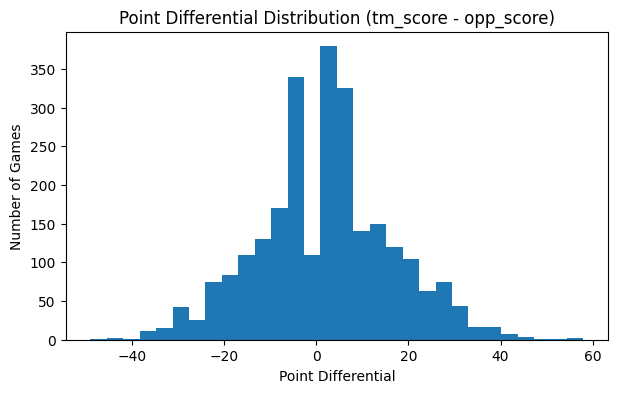

In [ ]:
# pd histogram
plt.figure(figsize=(7,4))
plt.hist(games_df["PointDiff"].dropna().values, bins=30)
plt.title("Point Differential Distribution (tm_score - opp_score)")
plt.xlabel("Point Differential"); plt.ylabel("Number of Games")
plt.show()

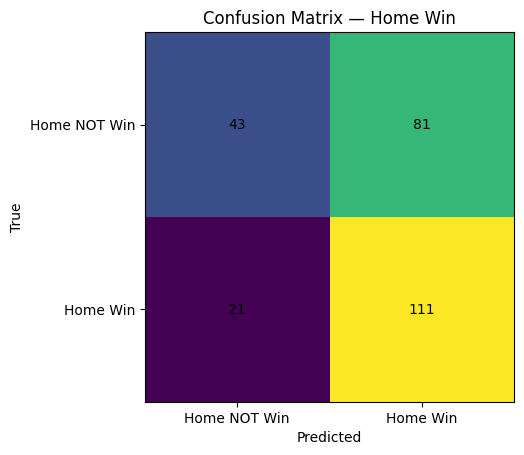

Test Accuracy: 0.6015625


In [ ]:
# confusion matrix
y_true = np.asarray(y_win_test).reshape(-1)
y_prob = np.asarray(win_prob).reshape(-1)
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.xticks([0, 1], ["Home NOT Win", "Home Win"])
plt.yticks([0, 1], ["Home NOT Win", "Home Win"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Home Win")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

print("Test Accuracy:", accuracy_score(y_true, y_pred))


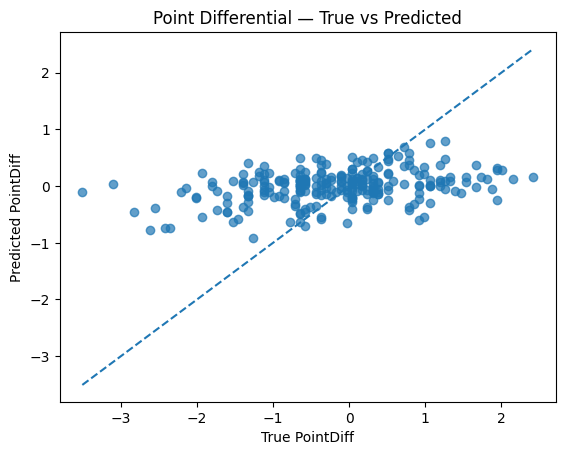

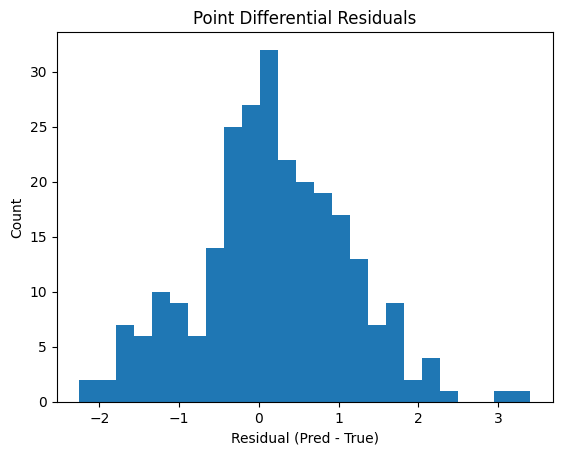

PD RMSE: 0.9630597565102682


In [ ]:
# Scatter: true vs predicted
plt.figure()
plt.scatter(y_pd_test, y_pd_pred, alpha=0.7)
mn = min(y_pd_test.min(), y_pd_pred.min())
mx = max(y_pd_test.max(), y_pd_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True PointDiff")
plt.ylabel("Predicted PointDiff")
plt.title("Point Differential — True vs Predicted")
plt.show()

# residual histogram
resid = y_pd_pred - y_pd_test
plt.figure()
plt.hist(resid, bins=25)
plt.xlabel("Residual (Pred - True)")
plt.ylabel("Count")
plt.title("Point Differential Residuals")
plt.show()

rmse = np.sqrt(mse(y_pd_test, y_pd_pred))
print("PD RMSE:", rmse)


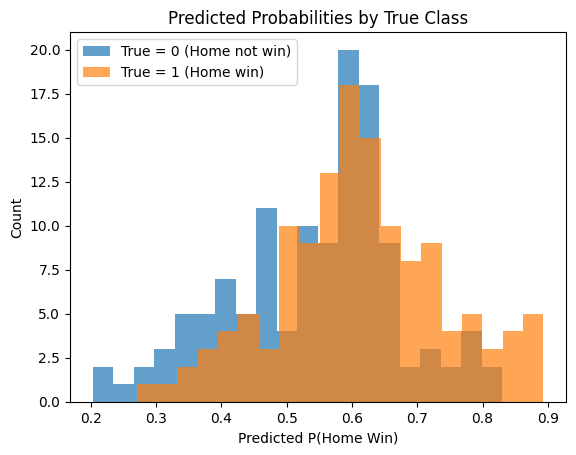

In [ ]:
# predicted prob histogram

y_true = np.asarray(y_win_test).reshape(-1)
y_prob = np.asarray(win_prob).reshape(-1)

p0 = y_prob[y_true == 0]
p1 = y_prob[y_true == 1]

plt.figure()
plt.hist(p0, bins=20, alpha=0.7, label="True = 0 (Home not win)")
plt.hist(p1, bins=20, alpha=0.7, label="True = 1 (Home win)")
plt.xlabel("Predicted P(Home Win)")
plt.ylabel("Count")
plt.title("Predicted Probabilities by True Class")
plt.legend()
plt.show()
